Imports

In [1]:
import sys
sys.path.insert(0, "/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/")
from pathlib import Path
import torch
from morphing_lander.data_utils.data_utils import get_data_from_rosbag, train_val_split, plot_data, plot_z_data, plot_12vector
from morphing_lander.cvae.train import TrainConfigCVAE, train
from morphing_lander.cvae.models import CVAE
from morphing_lander.mpc.parameters import params_

# get key parameters
model_states_in_idx  = params_.get('model_states_in_idx')
model_inputs_in_idx  = params_.get('model_inputs_in_idx')
model_phi_in         = params_.get('model_phi_in')
model_dt_in          = params_.get('model_dt_in')
model_states_out_idx = params_.get('model_states_out_idx')
model_ninputs        = params_.get('model_ninputs')
model_noutputs       = params_.get('model_noutputs')

print(f"model_ninputs:  {model_ninputs}")
print(f"model_noutputs: {model_noutputs}")

model_ninputs:  6
model_noutputs: 1


Get dataset ready for training

In [3]:
# get data from rosbag
bag_path    = '/home/m4pc/m4v2-code/m4_ws/rosbag2_2024_06_06-21_35_40'
type_path   = '/home/m4pc/m4v2-code/m4_ws/src/custom_msgs/msg/MPCStatus.msg'
topic_name  = 'mpc_status'

percent_val = 0.1
data = get_data_from_rosbag(bag_path,
                            type_path,
                            topic_name,
                            smooth_window=None
                            )

# split data into train and validation set
train_data_path = "/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/data/train_data.pt"
val_data_path = "/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/data/val_data.pt"

train_data, val_data = train_val_split(data,
                                       percent_val,
                                       model_states_in_idx,
                                       model_inputs_in_idx,
                                       model_phi_in,
                                       model_dt_in,
                                       model_states_out_idx,
                        )

# save train and validation data for future use
torch.save(train_data, train_data_path)
torch.save(val_data, val_data_path)

print(f"training data points: {train_data.shape[0]}")
print(f"validation data points: {val_data.shape[0]}")

AnyReaderError: The following paths are missing: [PosixPath('/home/m4pc/m4v2-code/m4_ws/rosbag2_2024_06_06-21_35_40')]

Plot dataset

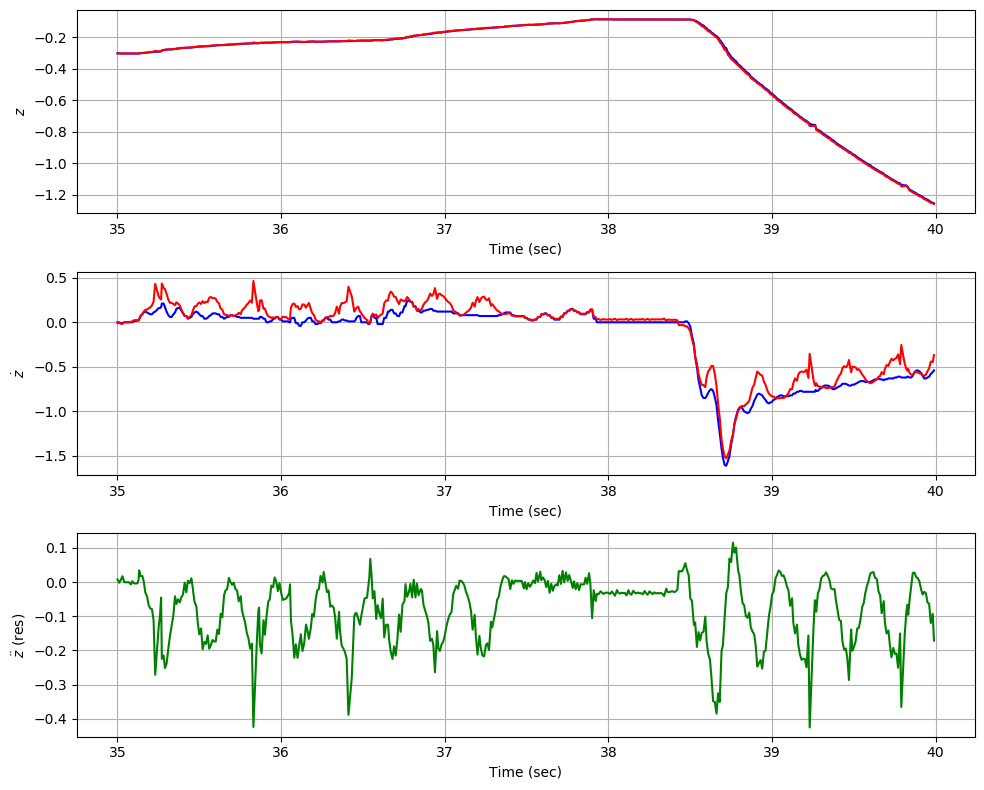

In [5]:
# plot_data(data,
#           start_time =None,
#           cutoff_time=None,
#           name=None,
#           inputs=True,
#           residuals=True)

plot_z_data(data,
            start_time =35,
            cutoff_time=40,
            )


Specify training configuration

In [3]:
# Specify the path for the learned models
output_path = Path(
    "/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/learned_models/"
)

train_config = TrainConfigCVAE(
    output_dim=model_noutputs,
    latent_dim=2,
    cond_dim=model_ninputs,
    encoder_layers=[128, 128],
    decoder_layers=[128, 128],
    prior_layers=[128, 128],
    batches_per_epoch=10,
    epochs=250,
    step_size=50,  # steps per decay for lr scheduler
    gamma=0.75,    # multiplicative decay for lr scheduler
    lr=5e-4,
    save_epochs=10,
    val_epochs=10,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

print(f"Device is: {train_config.device}")

Device is: cuda


Create the model

In [4]:
from morphing_lander.cvae.data import ResidualDataset

# create the morphing lander residual dataset
train_dataset = ResidualDataset(train_data_path, model_noutputs)
val_dataset   = ResidualDataset(val_data_path  , model_noutputs)

model = CVAE(
    output_dim=train_config.output_dim,
    latent_dim=train_config.latent_dim,
    cond_dim=train_config.cond_dim,
    encoder_layers=train_config.encoder_layers,
    decoder_layers=train_config.decoder_layers,
    prior_layers=train_config.prior_layers,
    cond_mean=train_dataset.cond_mean,
    cond_var=train_dataset.cond_var,
    output_mean=train_dataset.d_mean,
    output_var=train_dataset.d_var,
).to(train_config.device)

Train the model

In [5]:
# train the model 
model = train(model,train_dataset,val_dataset,train_config,output_path)

Epoch 0: train_loss=2.968801975250244, val_loss=1.6680546283721924
Epoch 10: train_loss=1.1831330060958862, val_loss=1.7712265968322753
Epoch 20: train_loss=1.0912784337997437, val_loss=1.6596028566360475
Epoch 30: train_loss=-0.3041146695613861, val_loss=1.7869872331619263
Epoch 40: train_loss=-0.09797607362270355, val_loss=1.6746880769729615
Epoch 50: train_loss=-0.41564810276031494, val_loss=1.5906262159347535
Epoch 60: train_loss=2.5012104511260986, val_loss=1.3810184478759766
Epoch 70: train_loss=-0.1179150938987732, val_loss=1.4179144382476807
Epoch 80: train_loss=0.606949508190155, val_loss=1.44309458732605
Epoch 90: train_loss=-0.6989206671714783, val_loss=1.485880708694458
Epoch 100: train_loss=-0.6321635246276855, val_loss=1.3826359748840331
Epoch 110: train_loss=-0.2815510034561157, val_loss=1.4236602067947388
Epoch 120: train_loss=0.5235327482223511, val_loss=1.456551432609558
Epoch 130: train_loss=0.21065819263458252, val_loss=1.4055357694625854
Epoch 140: train_loss=2.225

Validate

First need to set the residual model to the correct path in morphing_lander.mpc.parameters and compute the compiled residual function based on the trained CVAE

In [3]:
from morphing_lander.mpc.parameters import params_
params_.get('learned_model_path')

'/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/learned_models/2024-06-06_22-08-49'

In [5]:
import os
from casadi import external 
from morphing_lander.mpc.parameters import params_

# get residual model
l4c_residual_model = params_.get('l4c_residual_model')

# get c-compiled f_res function
from morphing_lander.mpc.dynamics import f_res, dynamics_with_res_func, rk4_with_res, rk4_with_disc_res, rk4_with_ground_effect, rk4
functions_folder = globals()['_dh'][0] / Path('compiled_functions')
os.chdir(functions_folder)
f_res().generate('f_res.c') 
# dynamics_with_res_func().generate('dynamics_with_res_func.c')
# rk4_with_res().generate('rk4_with_res.c')
rk4_with_disc_res().generate('rk4_with_disc_res')
# rk4_with_ground_effect().generate('rk4_with_ground_effect')
# rk4().generate('rk4')
os.system('gcc -fPIC -shared f_res.c -o f_res.so')
# os.system('gcc -fPIC -shared dynamics_with_res_func.c -o dynamics_with_res_func.so')
# os.system('gcc -fPIC -shared rk4_with_res.c -o rk4_with_res.so')
os.system('gcc -fPIC -shared rk4_with_disc_res.c -o rk4_with_disc_res.so')
# os.system('gcc -fPIC -shared rk4_with_ground_effect.c -o rk4_with_ground_effect.so')
# os.system('gcc -fPIC -shared rk4.c -o rk4.so')

f_res_c = external("f_res", functions_folder.absolute().as_posix() +"/f_res.so")
# dynamics_with_res_c = external("dynamics_with_res_func", functions_folder.absolute().as_posix() +"/dynamics_with_res_func.so")
# rk4_with_res_c = external("rk4_with_res", functions_folder.absolute().as_posix() +"/rk4_with_res.so")
rk4_with_disc_res_c = external("rk4_with_disc_res", functions_folder.absolute().as_posix() +"/rk4_with_disc_res.so")
# rk4_with_ground_effect_c = external("rk4_with_ground_effect", functions_folder.absolute().as_posix() +"/rk4_with_ground_effect.so")
# rk4_c = external("rk4", functions_folder.absolute().as_posix() +"/rk4.so")

Compute the predicted residual on the dataset

In [10]:
import numpy as np

# get residual predictions 
x_vec   = data['x_vec']
u_vec   = data['u_vec']
phi_vec = data['phi_vec']
dt_vec  = data['dt_vec']

cond = np.hstack((x_vec[:-1,model_states_in_idx],u_vec[:-1,model_inputs_in_idx]))
if model_phi_in:
    cond = np.hstack((cond,phi_vec[:-1,np.newaxis]))
if model_dt_in:
    cond = np.hstack((cond,dt_vec[:,np.newaxis]))

d_predicted = []
params = []
for i in range(cond.shape[0]):
    print(f"{i}/{cond.shape[0]}")
    params_ = l4c_residual_model.get_params(cond[i,:])
    d_predicted.append(f_res_c(cond[i,:],params_))
    params.append(params_)
d_predicted = np.array(d_predicted).squeeze()
params = np.array(params).squeeze()

# N = x_vec.shape[0]
# Nmid = int(N/2)
# cond1 = np.hstack((x_vec[:Nmid,[2,3,4,5,6,7,8]],u_vec[:Nmid,:],phi_vec[:Nmid,np.newaxis]))
# params1 = l4c_residual_model.get_params(cond1)

# cond2 = np.hstack((x_vec[Nmid:,[2,3,4,5,6,7,8]],u_vec[Nmid:,:],phi_vec[Nmid:,np.newaxis]))
# params2 = l4c_residual_model.get_params(cond2)

# params = np.hstack((params1,params2))
# cond   = np.hstack((cond1,cond2))

# f_res_predicted = []
# params = []
# for i in range(cond.shape[0]):
#     print(f"{i}/{cond.shape[0]}")
#     params_ = l4c_residual_model.get_params(cond[i,:])
#     f_res_predicted.append(f_res_c(cond[i,:],params_))
#     # f_res_predicted.append(f_res()(cond[i,:],params_))
#     params.append(params_)
# f_res_predicted = np.array(f_res_predicted).squeeze()
# params = np.array(params).squeeze()

0/19845
1/19845
2/19845
3/19845
4/19845
5/19845
6/19845
7/19845
8/19845
9/19845
10/19845
11/19845
12/19845
13/19845
14/19845
15/19845
16/19845
17/19845
18/19845
19/19845
20/19845
21/19845
22/19845
23/19845
24/19845
25/19845
26/19845
27/19845
28/19845
29/19845
30/19845
31/19845
32/19845
33/19845
34/19845
35/19845
36/19845
37/19845
38/19845
39/19845
40/19845
41/19845
42/19845
43/19845
44/19845
45/19845
46/19845
47/19845
48/19845
49/19845
50/19845
51/19845
52/19845
53/19845
54/19845
55/19845
56/19845
57/19845
58/19845
59/19845
60/19845
61/19845
62/19845
63/19845
64/19845
65/19845
66/19845
67/19845
68/19845
69/19845
70/19845
71/19845
72/19845
73/19845
74/19845
75/19845
76/19845
77/19845
78/19845
79/19845
80/19845
81/19845
82/19845
83/19845
84/19845
85/19845
86/19845
87/19845
88/19845
89/19845
90/19845
91/19845
92/19845
93/19845
94/19845
95/19845
96/19845
97/19845
98/19845
99/19845
100/19845
101/19845
102/19845
103/19845
104/19845
105/19845
106/19845
107/19845
108/19845
109/19845
110/19845


Plot the predicted residual vs actual residual

<Figure size 1000x800 with 0 Axes>

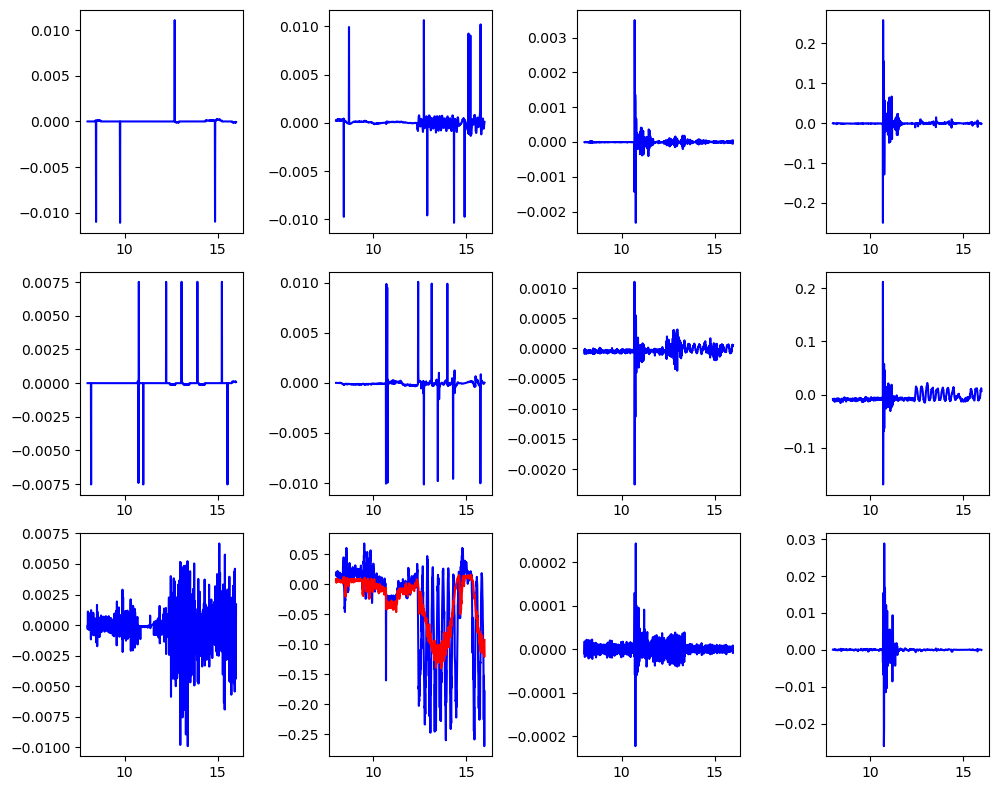

In [12]:
from morphing_lander.data_utils.data_utils import smooth
d = data['d']
t_vec     = data['t_vec']
f_res_int = data['f_res_int']
f_res_diff = data['f_res_diff']
# f_res_int_smooth = data['f_res_int_smooth']

# f_res_predicted_smooth = smooth(f_res_predicted,1)

fig,axs = plot_12vector(t_vec[:-1],
                        d,
                        handles = None,
                        start_time =8,
                        cutoff_time=16,
                        name=None,
                        title=None,
                        labels=None,
                        linestyle='b',
                        display=True,
                        overlay_vec=d_predicted,
                        overlay_idx=model_states_out_idx,
                        overlay_linestyle='r'
                        )


Plot the corrected dynamics predictions

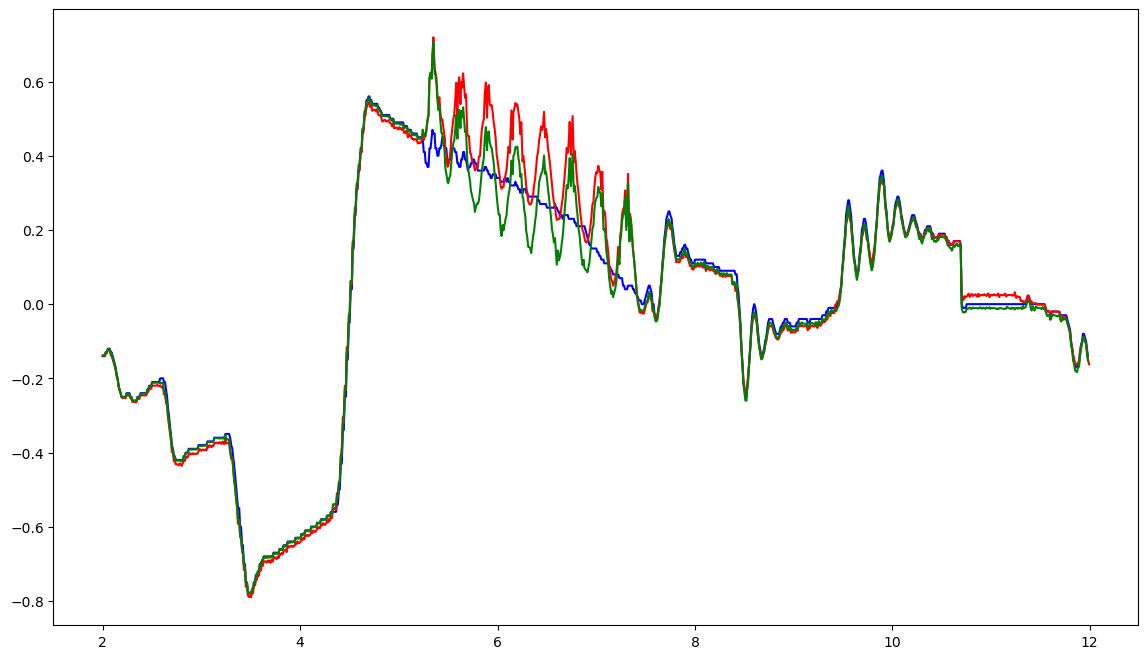

In [14]:
import matplotlib.pyplot as plt 
from morphing_lander.data_utils.data_utils import get_start_end_idx

t_vec      = data['t_vec']
dt_vec     = data['dt_vec']
x_vec      = data['x_vec']
x_next_vec = data['x_next_vec']

x_next_corrected = []
for i in range(x_next_vec.shape[0]):
    x_next_corrected.append(rk4_with_disc_res_c(dt_vec[i],x_vec[i,:],u_vec[i,:],phi_vec[i],params[i,:]))
x_next_corrected = np.array(x_next_corrected)

# x_next_corrected = []
# for i in range(x_next_vec.shape[0]):
#     x_next_corrected.append(rk4_with_res_c(dt_vec[i],x_vec[i,:],u_vec[i,:],phi_vec[i],params[i,:]))
# x_next_corrected = np.array(x_next_corrected)

start_idx,cutoff_idx = get_start_end_idx(t_vec,2,12)

plt.figure(figsize=(14,8))
plt.plot(t_vec[start_idx:cutoff_idx-1],x_vec[start_idx:cutoff_idx-1,8],'b')
plt.plot(t_vec[start_idx:cutoff_idx],x_next_vec[start_idx:cutoff_idx,8],'r')
plt.plot(t_vec[start_idx:cutoff_idx-1],x_next_corrected[start_idx:cutoff_idx-1,8],'g')

Test what the residual dynamics learned

In [15]:
z = np.linspace(0,-1.5,100)
u = np.array([1,1,1,1])
d_predicted = []
d_true = []
for z_ in z:
    cond = np.array([z_,u[0],u[1],u[2],u[3]])
    params_ = l4c_residual_model.get_params(cond)
    x = np.array([0,0,z_,0,0,0,0,0,0,0,0,0])
    phi = 0.0
    d_predicted.append(f_res_c(cond,params_))
    # print(rk4_with_ground_effect_c(0.01,x,u,phi))
    # d_true.append(rk4_with_ground_effect_c(0.01,x,u,phi) - rk4_c(0.01,x,u,phi))

AssertionError: 

In [ ]:
# plt.plot(z,np.array(d_predicted).squeeze(),'r')
plt.plot(z,np.array(d_true).squeeze()[:,8],'b')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
from morphing_lander.mpc.parameters import params_

kT      = params_.get('kT')
m       = params_.get('m')
g       = params_.get('g')

# get ground effect
R = 0.23
ground_effect_residual = []
for i in range(data['x_vec'].shape[0]):
    z     = data['x_vec'][i,2]
    u_tot = np.sum(data['u_vec'][i,:])
    phi   = data['phi_vec'][i]
    ground_effect = 1.0
    if abs(z/R) < 2:
        ground_effect = -3.0/2.0*abs(z/R) + 4.0
    ground_effect_residual.append(-(ground_effect-1) * kT * (u_tot) * np.cos(phi) / m)

plt.plot(data['t_vec'],ground_effect_residual)
plt.plot(data['t_vec'][:-1],data['f_res_int'][:,8])

# Plot histogram using pcolormesh
plt.scatter(data['x_vec'][1:,2],data['f_res_int'][:,8])
u_sum_vec = np.sum(data['u_vec'],axis=1)[:-1]
H,xedges,yedges = np.histogram2d(data['x_vec'][:,2],ground_effect_residual,bins=50)
fig, ax = plt.subplots(1,1)
ax.pcolormesh(xedges, yedges, H, cmap='rainbow')
# ax.plot(x, 2*np.log(x), 'k-')
# ax1.set_xlim(x.min(), x.max())
# ax1.set_ylim(y.min(), y.max())
ax.set_xlabel('z')
ax.set_ylabel('a_res')
ax.grid()
